In [40]:
%run function_dbs.py
%run MLRegression_dbs.py
%matplotlib inline

fs, color = 10, 'k'
today = ''.join(str(datetime.today()).split(' ')[0].split('-'))

## load data set and split into training and validation data

In [49]:
# select which ML algorithm for which analyte shall be analysed 
file_ox = '460nm/20221010_TrainingData-O2_balanced_absoluteInt_hPa.csv'
file_ph = '460nm/20221010_TrainingData-pH_balanced_absoluteInt_hPa.csv'

df_features = pd.read_csv(file_ox, sep='\t', index_col=0)

# ----------------------------------------------------------------------------------------
# split the data into training and validation data
y_truth = df_features.index              # n_samples (3720,) chosen analyte
X = df_features                          # shape (n_features, n_samples) with (3720, 151)
X_train, X_valid, truth_train, truth_valid = train_test_split(X, y_truth, test_size=0.2, random_state=42)
# X_train, X_valid = X_train.T, X_valid.T

print('in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples')
print('size of data sets:')
print('> training data  ', X_train.shape, '\n> validation data', X_valid.shape)

in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples
size of data sets:
> training data   (3130, 151) 
> validation data (783, 151)


### Naive approach for HPO

In [55]:
model = input('Select the ML algorithm that shall be optimized. RandomForest, DecisionTree or XGB:' )

print('')
if model == 'RandomForest':
    print('potential hyperparameters are: \n n_estimators \n min_weight_fraction_leaf \n min_samples_split \n min_samples_leaf', 
          '\n max_leaf_nodes \n max_features \n max_depth \n bootstrap')
elif model == 'DecisionTree':
    print('potential hyperparameters are: \n splitter \n max_depth \n min_samples_leaf \n min_weight_fraction_leaf, max_features, and', 
          'max_leaf_nodes')
elif model == 'XGB':
    print('potential hyperparameters are: \nn_estimators, max_depth, learning_rate, and min_child_weight')
    
params = input('select the hyperparameter that shall be optimized: ')

Select the ML algorithm that shall be optimized. RandomForest, DecisionTree or XGB:RandomForest

potential hyperparameters are: 
 n_estimators, 
 min_weight_fraction_leaf, 
 min_samples_split, 
 min_samples_leaf 
 max_leaf_nodes, 
 max_features, 
 max_depth, and 
 bootstrap
select the hyperparameter that shall be optimized: n_estimators


In [42]:
# select which ML algorithm that shall be optimized (HPO)

# Random Forest 
RF = RandomForestRegressor()

# model parameter that will be optimized
rf_random = {'n_estimators': [10, 15, 20, 25, 30, 40, 50, 75, 100, 150, 200], #[1, 25, 50, 75, 100, 150, 200],
             'max_features': [3, 4, 5, 7, 10, 15, 20], #[1, 2, 3, 4, 5, 7, 10, 20],
             'max_depth': [None, 1, 5, 10, 15, 20, 25, 30, 40, 50], #[None, 1, 3, 5, 7, 9, 11, 20, 50],
             'min_samples_split': [2, 3], #[2, 3, 4],
             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #[1, 2, 4, 6, 8, 10], 
             'bootstrap': [True, False],  
             'max_leaf_nodes': [10, 15, 20, 25, 50, 60, 70, 75, 80, 90, 100], #[None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
             'min_weight_fraction_leaf': [0, 0.2,0.4]} #[0, 0.1, 0.2, 0.3, 0.4, 0.45]}


# Decision Tree
DT = DecisionTreeRegressor() #make_pipeline(preprocessing.StandardScaler(), )

# model parameter that will be optimized
dt_random = {"splitter":["best", "random"],
             "max_depth" : [3, 4, 5, 6, 7, 8, 9, 10],
             "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7],
             "min_weight_fraction_leaf":[0, 0.1],
             "max_features":[None, 1, 2, 3, 4, 5, 6, 7],
             "max_leaf_nodes":[2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


# XGBoost
XG = XGBRegressor()

# model parameter that will be optimized
xg_random = {'n_estimators': [20, 30, 50, 70, 100, 150, 200, 250],
             'max_depth': [5, 7, 9],
             'learning_rate': [0, 0.05, 0.1, 0.15, 0.2],
             'min_child_weight': [0, 3, 5, 7]}


# ----------------------------------------------------------------------------------------
model_id = input('Which ML regressor shall be optimized - (1) Random Forest, (2) Decision tree, or (3) XGBoost? ')

Which ML regressor shall be optimized - (1) Random Forest, (2) Decision tree, or (3) XGBoost? 1


In [36]:
if model_id == '1':
    model = RF
    random_grid = rf_random
elif model_id == '2':
    model = DT
    random_grid = dt_random
elif model_id == '3':
    model = XG
    random_grid = xg_random
else:
    print('Please specify the model via its number: (1) Random Forest, (2) Decision tree, or (3) XGBoost')
    model = None
    random_grid = None

In [37]:
# Random search of parameters, using 3 fold cross validation (cv), 
# search across 100 different combinations, and use all available cores
if model != None:
    ML_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, 
                                   random_state=42, n_jobs=-1)

    # Fit the random search model
    ML_random.fit(X_train, truth_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [38]:
print('>> Best estimation of hyperparameter for ' + str(model)[:-2])
pd.DataFrame.from_dict(ML_random.best_params_, orient='index').T

>> Best estimation of hyperparameter for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ..


,n_estimators,min_child_weight,max_depth,learning_rate
0,250.0,3.0,9.0,0.05


#### Assess model performance with identified HPO

In [ ]:
if model_id == '1':
    model.n_estimators = ML_random.best_params_['n_estimators']
    model.min_weight_fraction_leaf = ML_random.best_params_['min_weight_fraction_leaf']
    model.min_samples_split = ML_random.best_params_['min_samples_split']
    model.min_samples_leaf = ML_random.best_params_['min_samples_leaf']
    model.max_leaf_nodes = ML_random.best_params_['max_leaf_nodes']
    model.max_features = ML_random.best_params_['max_features']
    model.max_depth = ML_random.best_params_['max_depth']
    model.bootstrap = ML_random.best_params_['bootstrap']
    
elif model_id == '2':
    model.splitter = ML_random.best_params_['splitter']
    model.min_weight_fraction_leaf = ML_random.best_params_['min_weight_fraction_leaf']
    model.min_samples_leaf = ML_random.best_params_['min_samples_leaf']
    model.max_leaf_nodes = ML_random.best_params_['max_leaf_nodes']
    model.max_features = ML_random.best_params_['max_features']
    model.max_depth = ML_random.best_params_['max_depth']  
    
elif model_id == '3':
    model.n_estimators = ML_random.best_params_['n_estimators']
    model.max_depth = ML_random.best_params_['max_depth']  
    model.learning_rate = ML_random.best_params_['learning_rate']
    model.min_child_weight = ML_random.best_params_['min_child_weight']
            
regressor = make_pipeline(preprocessing.StandardScaler(), model)

In [ ]:
# define the model performance with optimized hyper-parameters - re-execution 21 times to get the average results
[model_, y_predT, y_pred, para] = _fitPredict(model=regressor, X_train=X_train, truth_train=truth_train, 
                                              X_valid=X_valid, truth_valid=truth_valid)

# ---------------------------------------------------------
para = pd.DataFrame(para, index=['mae', 'rmse', 'sdz'])
para.to_clipboard()

## Naive Approach

In [26]:
if model == 'RandomForest':
    if params == 'n_estimators':
        ls_test = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]                                 # n_estimator
    elif params == 'min_weight_fraction_leaf':
        ls_test = [0, 0.1, 0.2, 0.3, 0.4, 0.5]                                                 # min_weight_fraction_leaf
    elif params == 'min_samples_split':
        ls_test = [0.1, 0.25, 0.5, 0.75, 0.9, 2, 3, 4, 5, 7, 10]                               # min_samples_split
    elif params == 'min_samples_leaf':
        ls_test = [1, 3, 4, 5, 6, 7, 8,9, 10]                                                  # min_samples_leaf
    elif params == 'max_leaf_nodes':
        ls_test = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]                    # max_leaf_nodes
    elif params == 'max_features':
        ls_test = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]                             # max_features
    elif params == 'max_depth':
        ls_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]     # max_depth
    else:
        ls_test = [True, False]
    mod_estimator = [RandomForestRegressor(bootstrap=l, n_jobs=-1, random_state=42, verbose=2) for l in ls_test]

elif model == 'DecisionTree':
    if params == 'splitter':
        ls_test = ['best', 'random']
    elif params == 'max_depth':
        ls_test = np.arange(1, 11)
    elif params == 'min_samples_leaf':
        ls_test = [1, 2, 3, 4, 5, 6, 7]
    elif params == 'min_weight_fraction_leaf':
        ls_test = np.arange(0.1, .6, 0.1)
    elif params == 'max_features':
        ls_test = [None, 1, 2, 3, 4, 5, 6, 7]
    elif params == 'max_leaf_nodes':
        ls_test = [2, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]                
    mod_estimator = [DecisionTreeRegressor(max_leaf_nodes=l, random_state=42) for l in ls_test]

elif model == 'XGB':
    if params == 'n_estimators':
        ls_test = np.arange(20, 270, 20)
    elif params == 'max_depth':
        ls_test = np.arange(1, 10)
    elif params == 'learning_rate':
        ls_test = [0, 0.05, 0.1, 0.15, 0.2]
    elif params == 'min_child_weight': 
        ls_test = np.arange(0, 8)
    mod_estimator = [XGBRegressor(min_child_weight=l, n_jobs=-1, random_state=42) for l in ls_test]
    
reg = [make_pipeline(preprocessing.StandardScaler(), m) for m in mod_estimator]

In [27]:
dpara = dict()
for en, reg_model in enumerate(reg):
    [model_, y_predT, y_pred, para] = _fitPredict(model=reg_model, X_train=X_train, truth_train=truth_train, X_valid=X_valid,
                                                    truth_valid=truth_valid)
    df_para = pd.DataFrame(para, index=['mae', 'rmse', 'sdz'])
    dpara[en] = df_para

In [28]:
df = pd.concat(dpara, axis=1).T[['mae', 'rmse']]

ddf_train = df.T.filter(like='training').T
ddf_train.index = ls_test

ddf_valid = df.T.filter(like='test').T
ddf_valid.index = ls_test

pd.concat([ddf_train, ddf_valid], axis=1).to_clipboard()

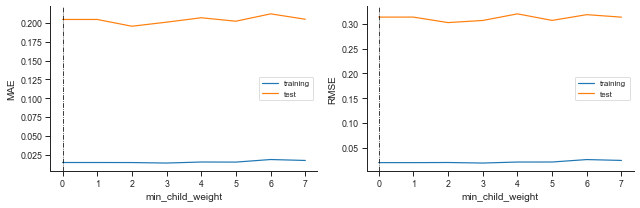

In [32]:
df = pd.concat(dpara, axis=1).T[['mae', 'rmse']]

fs = 10
x1 = 0.0

xnew = [0, 1] if params == 'bootstrap' else ls_test
# -----------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 3), ncols=2)
ax[0].set_ylabel('MAE', fontsize=fs), ax[0].set_xlabel(params, fontsize=fs)
ax[1].set_ylabel('RMSE', fontsize=fs), ax[1].set_xlabel(params, fontsize=fs)

ax[0].plot(xnew, ddf_train['mae'], label='training')
ax[0].plot(xnew, ddf_valid['mae'], label='test')
ax[1].plot(xnew, ddf_train['rmse'], label='training')
ax[1].plot(xnew, ddf_valid['rmse'], label='test')
ax[0].legend(fancybox=True, fontsize=fs*0.8), ax[1].legend(fancybox=True, fontsize=fs*0.8)

ax[0].axvline(x1, color='k', lw=.75, ls='-.')
ax[1].axvline(x1, color='k', lw=.75, ls='-.')


sns.despine(), plt.tight_layout()

#fig.savefig('20230110_pH-HPO_XGB_{}.png'.format(params), transparent=True, dpi=300)

In [51]:
#model = RandomForestRegressor(n_estimators=10, min_weight_fraction_leaf=0, min_samples_split=2, min_samples_leaf=4, 
#                              max_leaf_nodes=25, max_features=10, max_depth=5, bootstrap=True, n_jobs=-1, random_state=42, 
#                              verbose=2)
# model = DecisionTreeRegressor(splitter='best', max_depth=7, min_samples_leaf=1, min_weight_fraction_leaf=0,
#                                max_features=7, max_leaf_nodes=15, random_state=42)
model = XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.05, min_child_weight=7, n_jobs=-1, random_state=42)

regressor = make_pipeline(preprocessing.StandardScaler(), model)

# define the model performance with optimized hyper-parameters - re-execution 21 times to get the average results
[model_, y_predT, y_pred, para] = _fitPredict(model=regressor, X_train=X_train, truth_train=truth_train, 
                                              X_valid=X_valid, truth_valid=truth_valid)

# ---------------------------------------------------------
para = pd.DataFrame(para, index=['mae', 'rmse', 'sdz'])
para#.to_clipboard()

,training,test
mae,0.584771,1.668394
rmse,1.067840,4.540505
sdz,inf,inf
